In [83]:
using IL4model
using Plots
using Optim

results = optimizeParam()

 * Status: success

 * Candidate solution
    Final objective value:     1.713363e+01

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 3.47e-16 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.47e-22 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.84e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.66e-15 ≤ 1.0e-11
    |g(x)|                 = 3.17e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    2488
    f(x) calls:    2438
    ∇f(x) calls:   2438
    ∇²f(x) calls:  2418


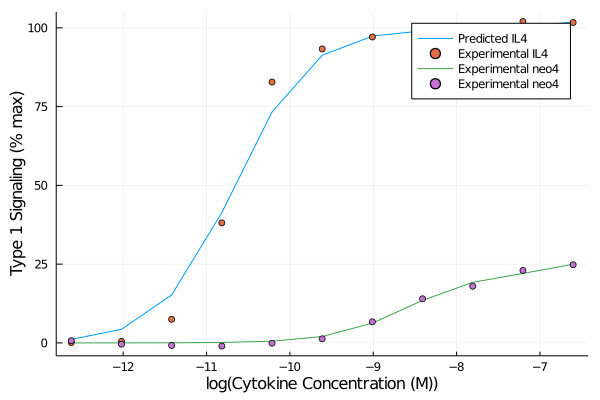

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [25]:
fitOut = abs.(Optim.minimizer(results))
plot(concs, ligOutLs(concs, fitOut[1:7])[:, 2], label = "Predicted IL4")
plot!(concs, IL4sig, seriestype = :scatter, label = "Experimental IL4")
plot!(concs, ligOutLs(concs, fitOut[[1, 8, 9, 10, 5, 6, 7]])[:, 2], label = "Experimental neo4")
plot!(concs, neo4sig, seriestype = :scatter, label = "Experimental neo4")
xlabel!("log(Cytokine Concentration (M))")
ylabel!("Type 1 Signaling (% max)")

In [16]:
fitOut

10-element Vector{Float64}:
     1.0000000001511365e6
     2.8770836205464065e-8
     9.32299823724329e-6
     5.172955639223641e-5
   885.140154419308
 12007.374435874974
  8000.228102204415
     1.555421671105853e-5
     1.7905071234774735e-6
     4.967880048072821e-5

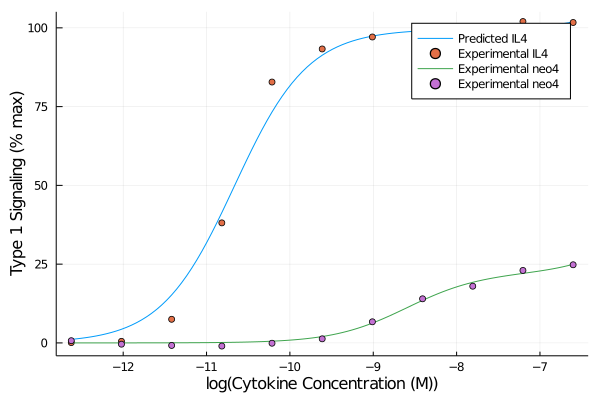

In [30]:
concs2 = LinRange(-12.6227, -6.60206, 101)
plot(concs2, ligOutLs(concs2, fitOut[1:7])[:, 2], label = "Predicted IL4")
plot!(concs, IL4sig, seriestype = :scatter, label = "Experimental IL4")
plot!(concs2, ligOutLs(concs2, fitOut[[1, 8, 9, 10, 5, 6, 7]])[:, 2], label = "Experimental neo4")
plot!(concs, neo4sig, seriestype = :scatter, label = "Experimental neo4")
xlabel!("log(Cytokine Concentration (M))")
ylabel!("Type 1 Signaling (% max)")

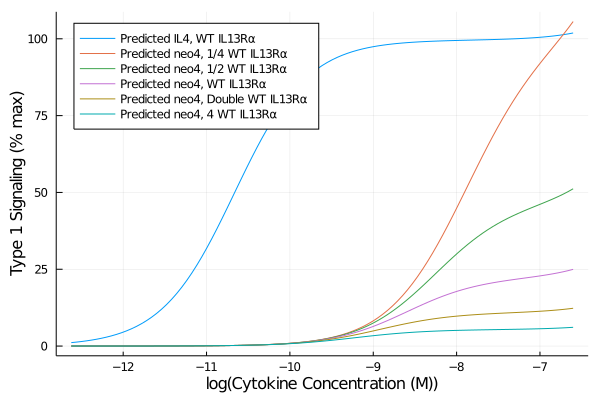

In [50]:
#concs2 = LinRange(-12.6227, -6.60206, 100)
plot(concs2, ligOutLs(concs2, fitOut[1:7])[:, 2], label = "Predicted IL4, WT IL13Rα1")
labels = ["Predicted neo4, 1/4 WT IL13Rα1", "Predicted neo4, 1/2 WT IL13Rα1", "Predicted neo4, WT IL13Rα1", "Predicted neo4, Double WT IL13Rα1", "Predicted neo4, 4 WT IL13Rα1"]
for i = -2:2
    loopFit = copy(fitOut)
    loopFit[6] *= 2^float(i)
    plot!(concs2, ligOutLs(concs2, loopFit[[1, 8, 9, 10, 5, 6, 7]])[:, 2], label = labels[i+3], legend=:topleft)
end
xlabel!("log(Cytokine Concentration (M))")
ylabel!("Type 1 Signaling (% max)")

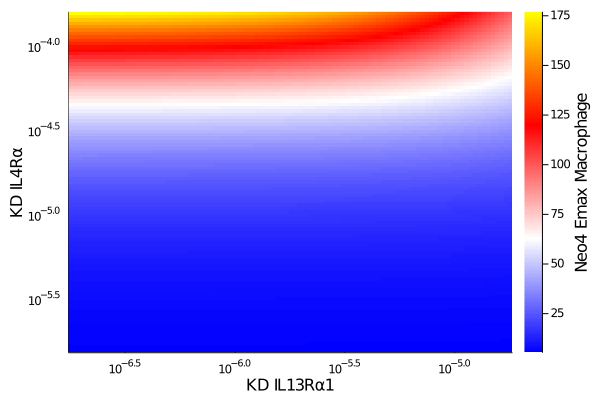

In [82]:
using DataFrames
numPoints=101
mult = 10 .^ range(log10(1e-1), log10(1e1), length = numPoints)
KDas = mult .* fitOut[8]
KD13s = mult .* fitOut[9]
EmaxNeo = Array{Float64}(undef, numPoints, numPoints)

for i = 1:numPoints
    for j = 1:numPoints
        loopFitHM = copy(fitOut)
        loopFitHM[9] = KD13s[i]
        loopFitHM[8] = KDas[j]
        EmaxNeo[i, j] = ligOutLs(concs2, loopFitHM[[1, 8, 9, 10, 5, 6, 7]])[end, 2]
    end
end

gr()
heatmap(KD13s,
    KDas, EmaxNeo,
    c=cgrad([:blue, :white,:red, :yellow]),
    xlabel="KD IL13Rα1", ylabel="KD IL4Rα", xscale = :log10, yscale = :log10, colorbar_title="Neo4 Emax Macrophage")
